In [1]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import time
from pymongo import MongoClient
from pprint import PrettyPrinter
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg

Connecting to the database server in the localhost

In [2]:
client = MongoClient(host="localhost", port=27017)


Instantiates a PrettyPrinter, and assigns it to the variable pp.
Then prints a list of the databases available on client

In [3]:
pp = PrettyPrinter(indent=2)
pp.pprint(list(client.list_databases()))

[ {'empty': False, 'name': 'Air-Q', 'sizeOnDisk': 8400896},
  {'empty': False, 'name': 'admin', 'sizeOnDisk': 40960},
  {'empty': False, 'name': 'config', 'sizeOnDisk': 73728},
  {'empty': False, 'name': 'local', 'sizeOnDisk': 73728}]


Assign the `Air` collection in the `db` database to the variable name `dar_air`

In [4]:
db = client['Air-Q']
dar_air = db['Air']
print("ds_app type:", type(dar_air))

ds_app type: <class 'pymongo.synchronous.collection.Collection'>


Checking how many documents are in the `dar_air` collection

In [14]:
dar_air.count_documents({})

208486

Retrieving one document from the `dar_air` collection, and assign it to the variable name `result`

In [15]:
result = dar_air.find_one()
pp.pprint(result)

{ '_id': ObjectId('67d6b0e219c300456f7d44ae'),
  'lat': -6.818,
  'location': 11,
  'lon': 39.285,
  'sensor_id': 34,
  'sensor_type': 'DHT22',
  'timestamp': datetime.datetime(2017, 12, 1, 0, 0, 0, 140000),
  'value': 74.1,
  'value_type': 'humidity'}


Determining how many locations have been used in the `dar_air` collection.

In [16]:
dar_air.distinct("location")

[11]

Determining how many types of measurements have been taken in the `dar_air` collection.

In [17]:
dar_air.distinct('value_type')

['P1', 'P2', 'humidity', 'temperature']

Determine which site in the Dar es Salaam collection has the most sensor readings

In [18]:
result = dar_air.aggregate(
    [
        {'$group': {'_id': '$value_type', 'count': {'$count': {}}}}
    ]
)
pp.pprint(list(result))

[ {'_id': 'humidity', 'count': 34620},
  {'_id': 'P1', 'count': 69623},
  {'_id': 'P2', 'count': 69623},
  {'_id': 'temperature', 'count': 34620}]


Wrangle function extracts the PM2.5 readings from the site that has the most total readings in the Dar es Salaam collection.
Localize reading time stamps to the timezone for "Africa/Dar_es_Salaam".
Remove all outlier PM2.5 readings that are above 100.
Resample the data to provide the mean PM2.5 reading for each hour.
Impute any missing values using the forward-fill method.

In [23]:
def wrangle(collection):
    results = dar_air.find(
        {"value_type": "P2"},  # Filter for P2 readings
        projection={"timestamp": 1, "value": 1, "_id": 0}  # Project only relevant fields
    )

    # Read results into DataFrame
    df = pd.DataFrame(list(results)).set_index("timestamp")

    # Localize timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Dar_es_Salaam")

    # Renaming the `value` column to `PM2.5`
    df.rename(columns={"value": "PM2.5"}, inplace=True)

    # Remove outliers
    df = df[df["PM2.5"] < 100]

    # Resample and forward-fill
    y = df['PM2.5'].resample('1h').mean().fillna(method='ffill')

    return y

In [24]:
y = wrangle(dar_air)
y.head()

/tmp/ipykernel_17753/1447311833.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df['PM2.5'].resample('1h').mean().fillna(method='ffill')


timestamp
2017-12-01 03:00:00+03:00     4.070513
2017-12-01 04:00:00+03:00     6.073151
2017-12-01 05:00:00+03:00    14.670833
2017-12-01 06:00:00+03:00    15.996438
2017-12-01 07:00:00+03:00    17.660822
Freq: h, Name: PM2.5, dtype: float64

In [25]:
len(y)

744

Creates a time series plot of the readings in y.

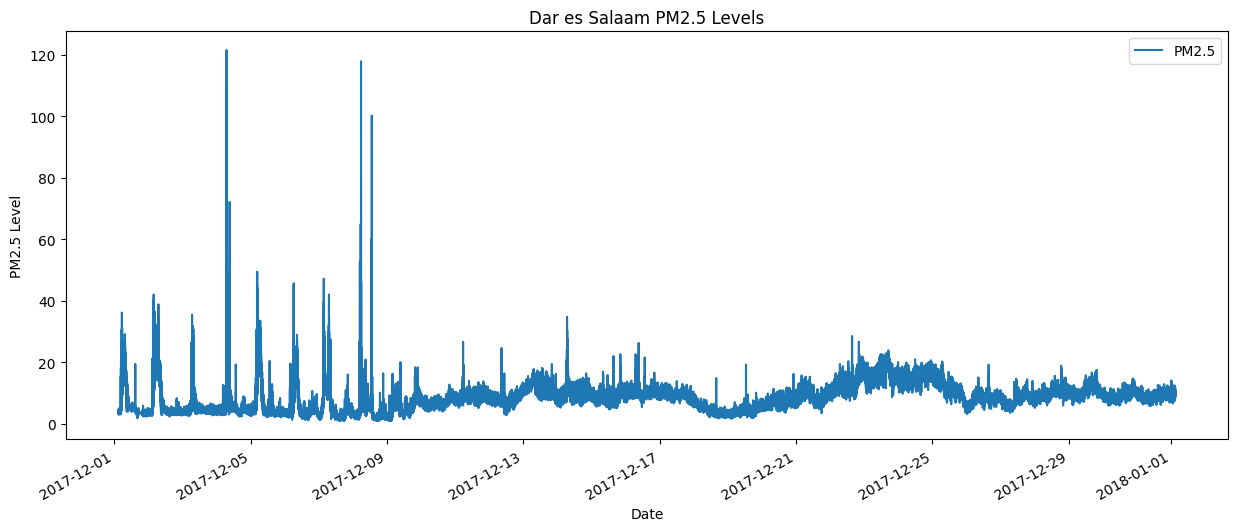

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))

y.plot(xlabel='Date', ylabel='PM2.5 Level', title='Dar es Salaam PM2.5 Levels', ax=ax);

plt.savefig("images/3-5-5.png", dpi=150)


Plots the rolling average of the readings in y use a window size of 168 (the number of hours in a week).

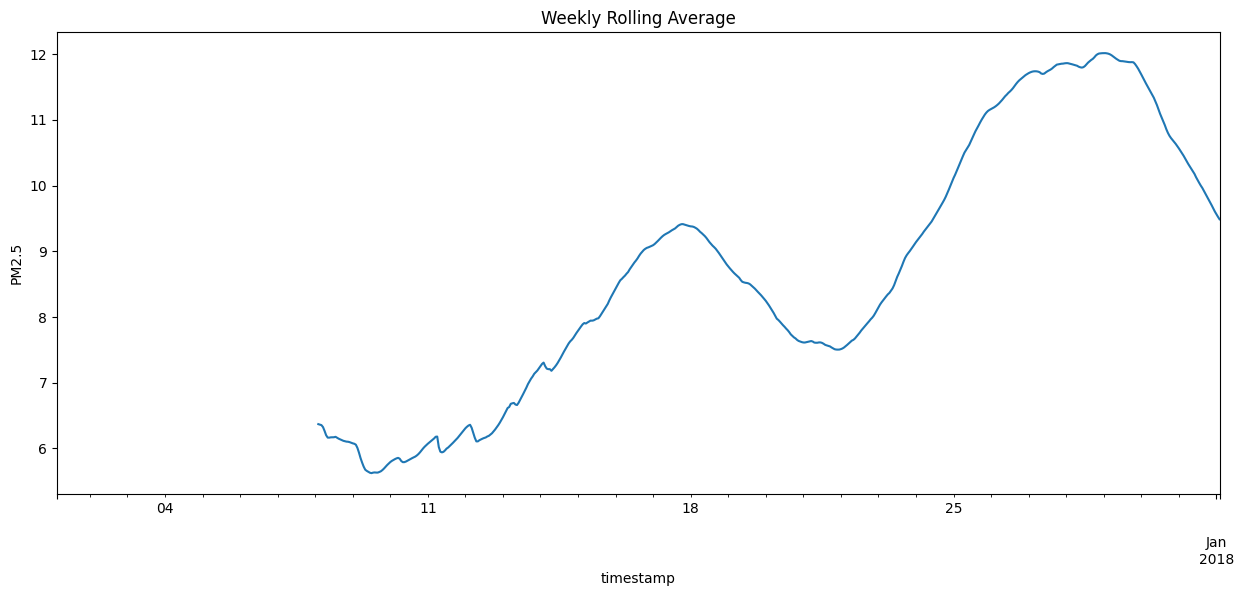

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))

y.rolling(168).mean().plot(ax=ax, ylabel='PM2.5', title='Weekly Rolling Average');

plt.savefig("images/3-5-6.png", dpi=150)

Creates an ACF plot for the data in y, labelling the x-axis as "Lag [hours]" and the y-axis as "Correlation Coefficient"

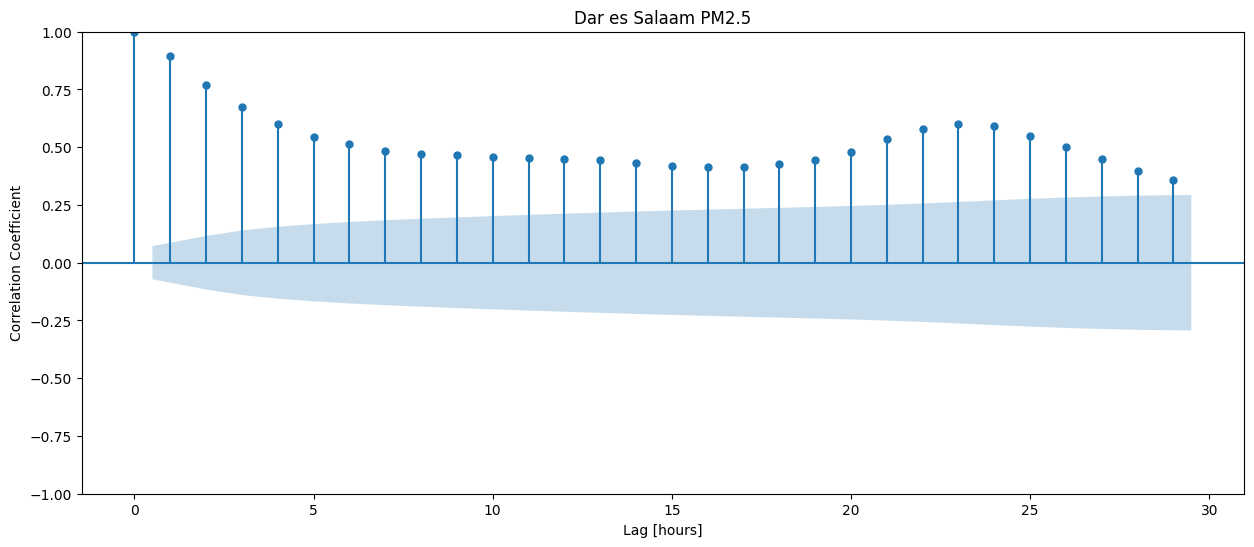

In [27]:
fig, ax = plt.subplots(figsize=(15, 6))

plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");
plt.title('Dar es Salaam PM2.5')

plt.savefig("images/3-5-7.png", dpi=150)

Creates a PACF plot for the data in y, labelling the x-axis as "Lag [hours]" and the y-axis as "Correlation Coefficient"

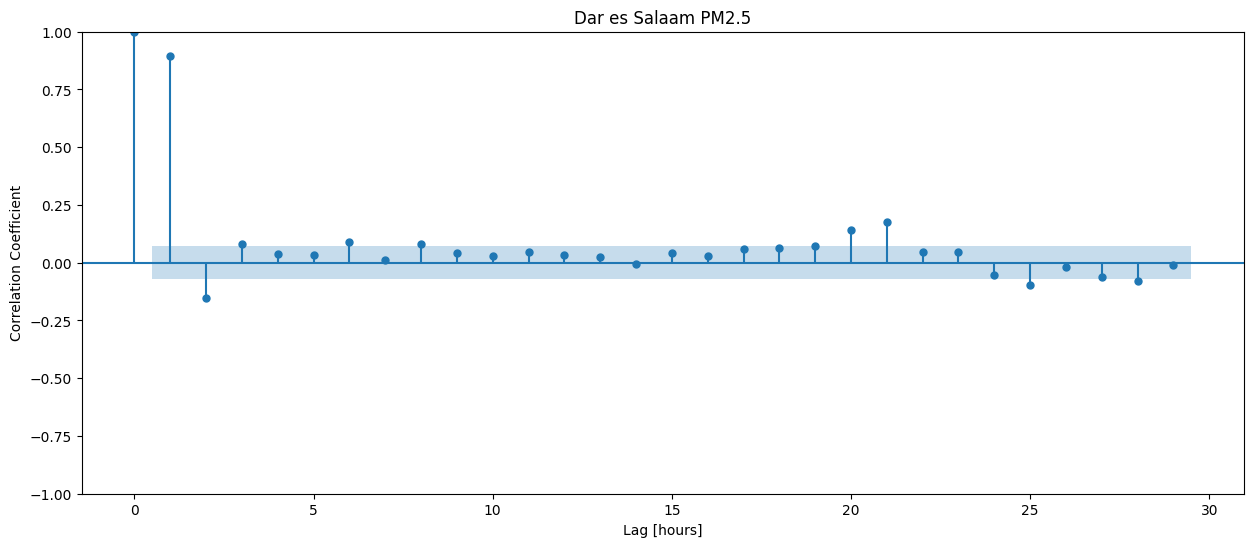

In [28]:
fig, ax = plt.subplots(figsize=(15, 6))

plot_pacf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");
plt.title('Dar es Salaam PM2.5')

plt.savefig("images/3-5-8.png", dpi=150)

Split y into training and test sets, with the first 90% of the data in the training set, remaining 10% in the test set.

In [29]:
cutoff_test = int(len(y) * 0.9)
y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (669,)
y_test shape: (75,)


Establishing the baseline mean absolute error for the model:

In [30]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean P2 Reading: 8.436214575047591
Baseline MAE: 3.228700489649769


Uses an AutoReg model to predict PM2.5 readings. lags from 1 to 30. 
Each time a new model is trained, its mean absolute error is calculated and the result appended to the list maes.
Results stored in the Series 'mae_series'.

In [31]:
#Create range to test different lags
p_params = range(1, 31)

# Create empty list to hold mean absolute error scores
maes = []

# Iterate through all values of p in `p_params`
for p in p_params:
    # Build model
    model = AutoReg(y_train, lags=p).fit()

    # Make predictions on training data, dropping null values caused by lag
    y_pred = model.predict().dropna()

    # Calculate mean absolute error for training data vs predictions
    mae = mean_absolute_error(y_train.iloc[p:], y_pred)

    # Append `mae` to list `maes`
    maes.append(mae)

# Put list `maes` into Series with index `p_params`
mae_series = pd.Series(maes, name="mae", index=p_params)

# Inspect head of Series
mae_series.head()

1    0.908429
2    0.889631
3    0.873786
4    0.871509
5    0.869632
Name: mae, dtype: float64

In [57]:
mae_series

1     0.908429
2     0.889631
3     0.873786
4     0.871509
5     0.869632
6     0.858045
7     0.853305
8     0.847048
9     0.845058
10    0.845854
11    0.846254
12    0.847010
13    0.848160
14    0.847776
15    0.848180
16    0.848802
17    0.848950
18    0.855423
19    0.859671
20    0.867887
21    0.870132
22    0.872118
23    0.879713
24    0.874649
25    0.855774
26    0.845343
27    0.837950
28    0.840930
29    0.842235
30    0.841608
Name: mae, dtype: float64

Determines what value for p provides the best performance, then builds and trains `best_model` using the best hyperparameter value

In [32]:
best_p = mae_series.idxmin()
best_model = AutoReg(y_train, lags=best_p).fit()

Calculates the training residuals for best_model and assign the result to y_train_resid

In [33]:
y_train_resid = model.resid
y_train_resid.name = "residuals"
y_train_resid.head()

timestamp
2017-12-02 09:00:00+03:00   -3.759362
2017-12-02 10:00:00+03:00   -0.243389
2017-12-02 11:00:00+03:00   -1.153877
2017-12-02 12:00:00+03:00   -0.722181
2017-12-02 13:00:00+03:00   -0.728057
Freq: h, Name: residuals, dtype: float64

Creates a histogram of y_train_resid. Labels: x-axis as "Residuals" and the y-axis as "Frequency"

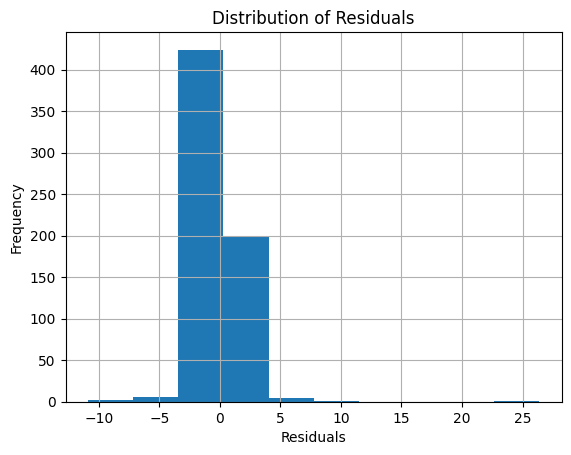

In [34]:
y_train_resid.hist()
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.savefig("images/3-5-14.png", dpi=150)

Creates an ACF plot for y_train_resid. Label: x-axis as "Lag [hours]" and y-axis as "Correlation Coefficient"

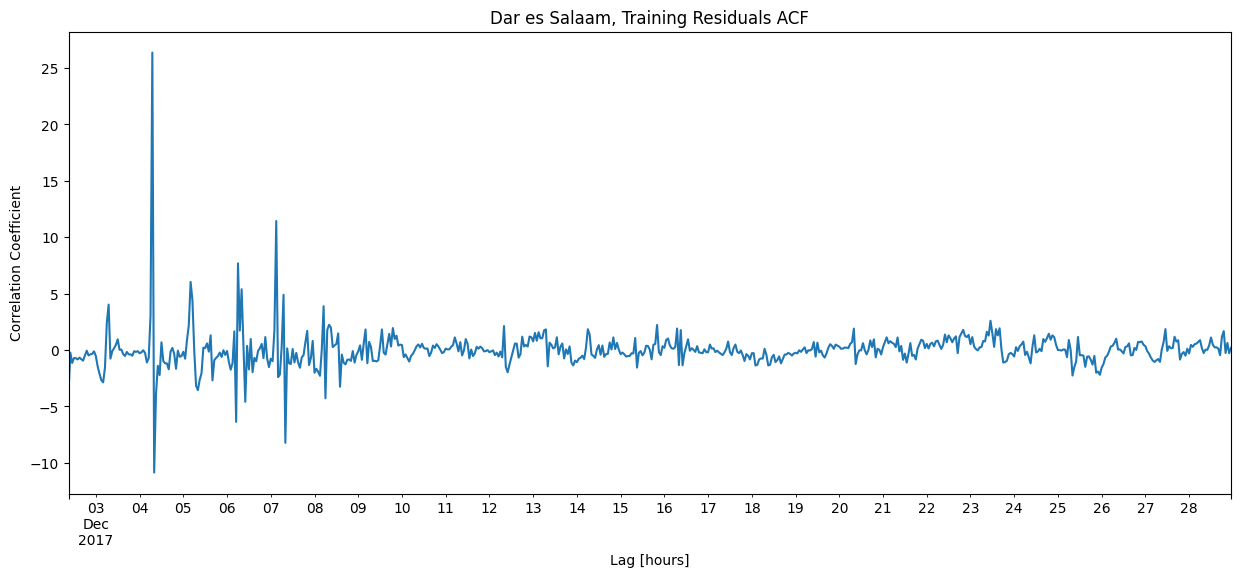

In [35]:
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel='Correlation Coefficient', xlabel='Lag [hours]', title='Dar es Salaam, Training Residuals ACF', ax=ax)

plt.savefig("images/3-5-15.png", dpi=150)

Using the `plot_diagnostics` method to check the residuals for the model.

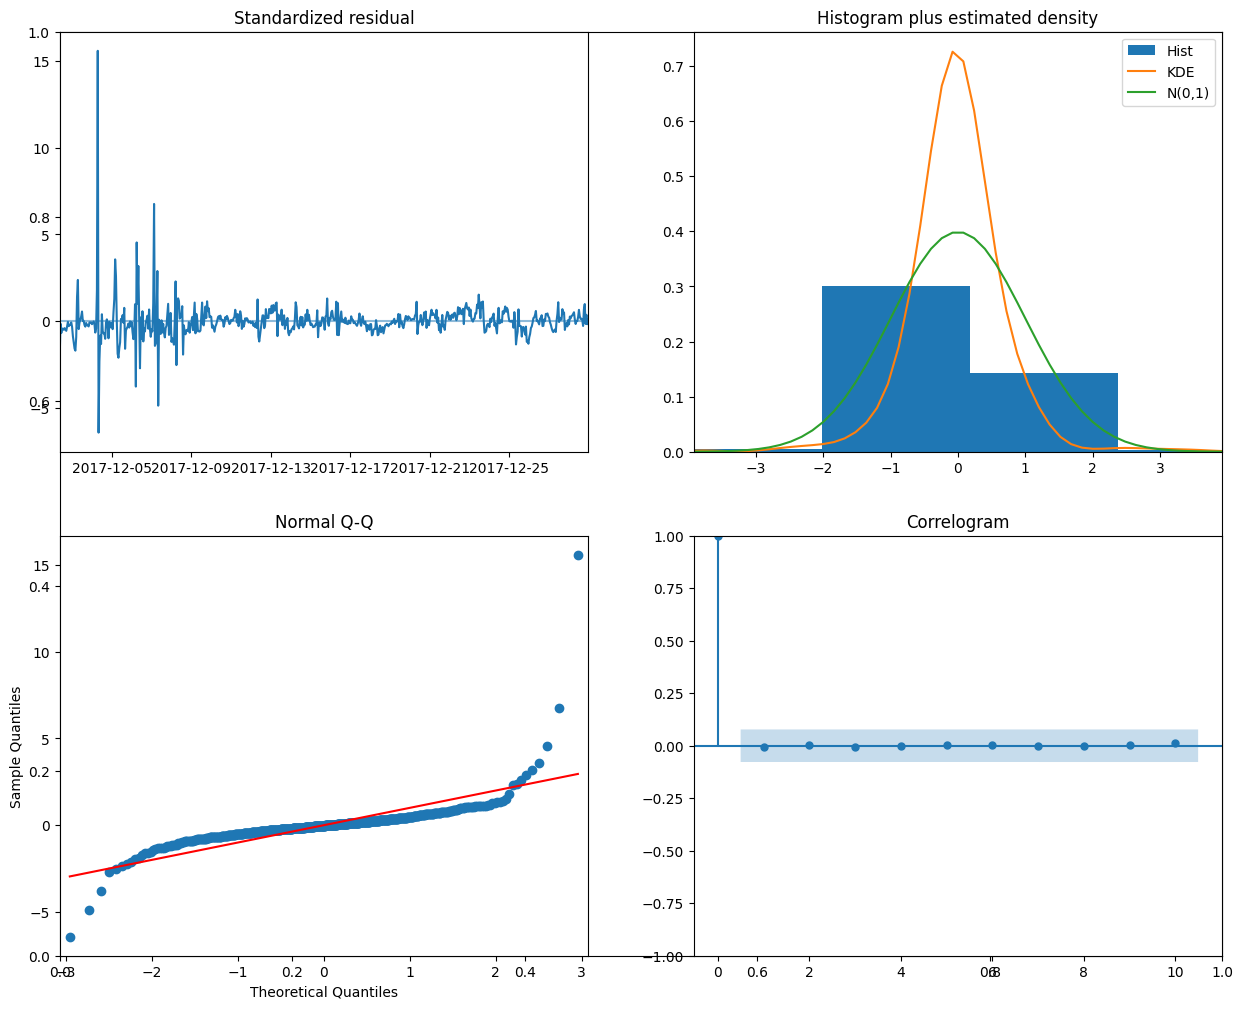

In [36]:
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig);

Performing walk-forward validation for the model for the entire test set y_test. Stores the model's predictions in the Series y_pred_wfv. Index of the series is "timestamp".

In [38]:
y_pred_wfv = pd.Series()
history = y_train.copy()
best_p = mae_series.idxmin()

for i in range(len(y_test)):
    model = AutoReg(history, lags=best_p).fit()
    next_pred = model.forecast()
    
    y_pred_wfv = pd.concat([y_pred_wfv, pd.Series(next_pred)], ignore_index=False)
    history = pd.concat([history, y_test[next_pred.index]])

y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()

/tmp/ipykernel_17753/2757563421.py:9: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_pred_wfv = pd.concat([y_pred_wfv, pd.Series(next_pred)], ignore_index=False)


timestamp
2017-12-29 00:00:00+03:00    10.096354
2017-12-29 01:00:00+03:00    10.213124
2017-12-29 02:00:00+03:00    10.013166
2017-12-29 03:00:00+03:00    10.126050
2017-12-29 04:00:00+03:00    10.246245
Freq: h, Name: prediction, dtype: float64

Puts the values for y_test and y_pred_wfv into the DataFrame df_pred_test
Then plot df_pred_test using plotly express.

In [39]:
df_pred_test = pd.DataFrame({'y_test': y_test,'y_pred_wfv': y_pred_wfv}, index=y_test.index)
fig = px.line(df_pred_test)
fig.update_layout(
    title="Dar es Salaam, WFV Predictions",
    xaxis_title="Date",
    yaxis_title="PM2.5 Level",
)

fig.write_image("images/3-5-18.png", scale=1, height=500, width=700)

fig.show()